# 1. Daten aus CSV-File in Datenbank speichern

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
from sklearn.ensemble import IsolationForest
from mpl_toolkits.mplot3d import Axes3D
import itertools
import re

# Pfad zur CSV-Datei
csv_file_path = 'Daten.csv'

# Lese die CSV-Datei mit Semikolon als Trennzeichen
data = pd.read_csv(csv_file_path, sep=';')

# Zeige Informationen über die Daten an
print("\nInformationen zum Datensatz:")
print(f"Anzahl Zeilen: {data.shape[0]}")
print(f"Anzahl Spalten: {data.shape[1]}")
print("\nSpaltennamen:")
print(data.columns.tolist())

# Verbindung zur SQLite-Datenbank herstellen (oder erstellen, falls sie nicht existiert)
db_path = 'datenbank.db'
conn = sqlite3.connect(db_path)

# Daten in die SQL-Datenbank schreiben
table_name = 'daten_tabelle'
data.to_sql(table_name, conn, if_exists='replace', index=False)

print(f"\nDaten wurden erfolgreich in die Tabelle '{table_name}' der Datenbank '{db_path}' gespeichert.")

# Verbindung schließen
conn.close()


Informationen zum Datensatz:
Anzahl Zeilen: 1000000
Anzahl Spalten: 6

Spaltennamen:
['TimeStamp', 'ActualPos', 'ActualForce', 'Nahtnummer', 'LaserPwr', 'Befehl']

Daten wurden erfolgreich in die Tabelle 'daten_tabelle' der Datenbank 'datenbank.db' gespeichert.


# 2. Datenbereinigung und Validierung numerischer Werte der DB

In [23]:
# Funktion zur Zeichen-für-Zeichen-Analyse und Validierung von Zahlen
def parse_number(value):
    try:
        # Entferne führende/trailing Whitespaces
        value = value.strip()
        
        # Ersetze Komma durch Punkt, falls vorhanden (für Dezimalzahlen)
        value = value.replace(',', '.')
        
        # Prüfe, ob der Wert eine Ganzzahl oder Kommazahl ist (positiv/negativ)
        if re.match(r'^-?\d+(\.\d+)?$', value):  # Regex für Ganzzahlen und Kommazahlen
            return float(value)  # Konvertiere in eine Zahl
        else:
            return None  # Ungültige Werte zurückgeben
    except:
        return None

# Verbindung zur ursprünglichen Datenbank herstellen
source_db = "datenbank.db"
clean_db = "datenbank_clean.db"

# Spaltennamen
columns = ['TimeStamp', 'ActualPos', 'ActualForce', 'Nahtnummer', 'LaserPwr', 'Befehl']

# Verbindung zur ursprünglichen Datenbank
conn_source = sqlite3.connect(source_db)

# Daten aus der ursprünglichen Datenbank lesen
query = f"SELECT {', '.join(columns)} FROM daten_tabelle"  # Tabellennamen angepasst
df = pd.read_sql_query(query, conn_source)

# Verbindung zur ursprünglichen Datenbank schließen
conn_source.close()

# Datenbereinigung
# Anzahl der Zeilen vor dem Entfernen von fehlenden Werten
initial_row_count = len(df)

# Entferne Zeilen mit fehlenden Werten
df_cleaned = df.dropna().copy()

# Anzahl der Zeilen nach dem Entfernen von fehlenden Werten
after_initial_cleaning_count = len(df_cleaned)

# Konvertiere die Spalten 'ActualPos', 'ActualForce' und 'LaserPwr' durch Zeichen-für-Zeichen-Analyse
for col in ['ActualPos', 'ActualForce', 'LaserPwr']:
    # Wende die parse_number-Funktion auf jede Zelle der Spalte an
    df_cleaned[col] = df_cleaned[col].astype(str).apply(parse_number)

# Entferne erneut Zeilen mit ungültigen Werten (z.B. wenn Konvertierung fehlschlug)
invalid_rows = df_cleaned[df_cleaned[['ActualPos', 'ActualForce', 'LaserPwr']].isnull().any(axis=1)]
after_conversion_cleaning_count = len(df_cleaned)

# Entferne ungültige Zeilen
df_cleaned = df_cleaned.dropna()

# Anzahl der Zeilen nach dem Entfernen ungültiger Werte
final_row_count = len(df_cleaned)

# Entferne Werte außerhalb der Limits
# Anzahl der Zeilen vor dem Entfernen von Werten außerhalb der Limits
before_limit_cleaning_count = len(df_cleaned)

# Filterbedingungen für die Limits
df_cleaned = df_cleaned[
    (df_cleaned['ActualPos'] <= 10) & (df_cleaned['ActualPos'] >= -10) &  # Limits für ActualPos
    (df_cleaned['ActualForce'] <= 1000) & (df_cleaned['ActualForce'] >= -2000) &  # Limits für ActualForce
    (df_cleaned['LaserPwr'] <= 500) & (df_cleaned['LaserPwr'] >= 0)  # Limits für LaserPwr
]

# Anzahl der Zeilen nach dem Entfernen von Werten außerhalb der Limits
after_limit_cleaning_count = len(df_cleaned)

# Entferne Ausreißer mit dem Interquartilsabstand (IQR)
numerical_columns = ['ActualPos', 'ActualForce', 'LaserPwr']
Q1 = df_cleaned[numerical_columns].quantile(0.25)
Q3 = df_cleaned[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Daten innerhalb des IQR-Bereichs behalten
df_cleaned = df_cleaned[~((df_cleaned[numerical_columns] < (Q1 - 1.5 * IQR)) | (df_cleaned[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Anzahl der Zeilen nach der IQR-Bereinigung
after_iqr_cleaning_count = len(df_cleaned)

# Verbindung zur bereinigten Datenbank herstellen
conn_clean = sqlite3.connect(clean_db)

# Bereinigte Daten in die neue Datenbank schreiben
df_cleaned.to_sql('cleaned_data', conn_clean, if_exists='replace', index=False)

# Verbindung zur bereinigten Datenbank schließen
conn_clean.close()

# Ausgabe der gelöschten Werte
print(f"Anzahl der ursprünglichen Zeilen: {initial_row_count}")
print(f"Anzahl der Zeilen nach dem Entfernen fehlender Werte: {after_initial_cleaning_count}")
print(f"Anzahl der Zeilen nach der Konvertierung: {after_conversion_cleaning_count}")
print(f"Anzahl der Zeilen nach dem Entfernen von Werten außerhalb der Limits: {after_limit_cleaning_count}")
print(f"Anzahl der Zeilen nach der IQR-Bereinigung: {after_iqr_cleaning_count}")
print(f"Anzahl der endgültigen Zeilen: {len(df_cleaned)}")

print(f"Vor der Konvertierung entfernte Zeilen: {initial_row_count - after_initial_cleaning_count}")
print(f"Nach der Konvertierung entfernte Zeilen: {after_initial_cleaning_count - after_conversion_cleaning_count}")
print(f"Zeilen entfernt aufgrund von Limits: {after_conversion_cleaning_count - after_limit_cleaning_count}")
print(f"Zeilen entfernt aufgrund der IQR-Bereinigung: {after_limit_cleaning_count - after_iqr_cleaning_count}")

print("Daten wurden erfolgreich bereinigt und in datenbank_clean.db gespeichert.")

Anzahl der ursprünglichen Zeilen: 1000000
Anzahl der Zeilen nach dem Entfernen fehlender Werte: 998925
Anzahl der Zeilen nach der Konvertierung: 998925
Anzahl der Zeilen nach dem Entfernen von Werten außerhalb der Limits: 813215
Anzahl der Zeilen nach der IQR-Bereinigung: 532581
Anzahl der endgültigen Zeilen: 532581
Vor der Konvertierung entfernte Zeilen: 1075
Nach der Konvertierung entfernte Zeilen: 0
Zeilen entfernt aufgrund von Limits: 185710
Zeilen entfernt aufgrund der IQR-Bereinigung: 280634
Daten wurden erfolgreich bereinigt und in datenbank_clean.db gespeichert.


# 3. Datenvisualisierung und Analyse numerischer Spalten

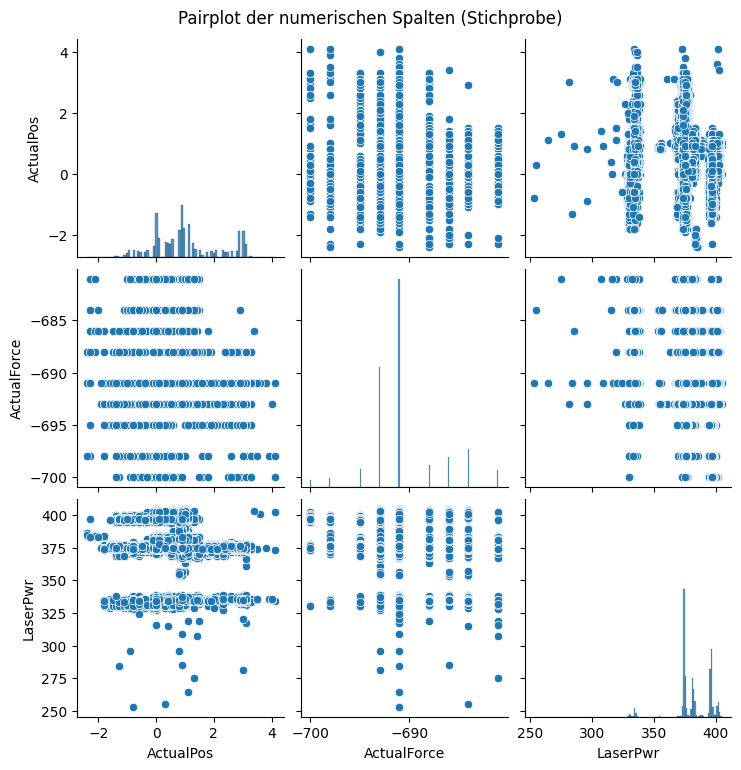

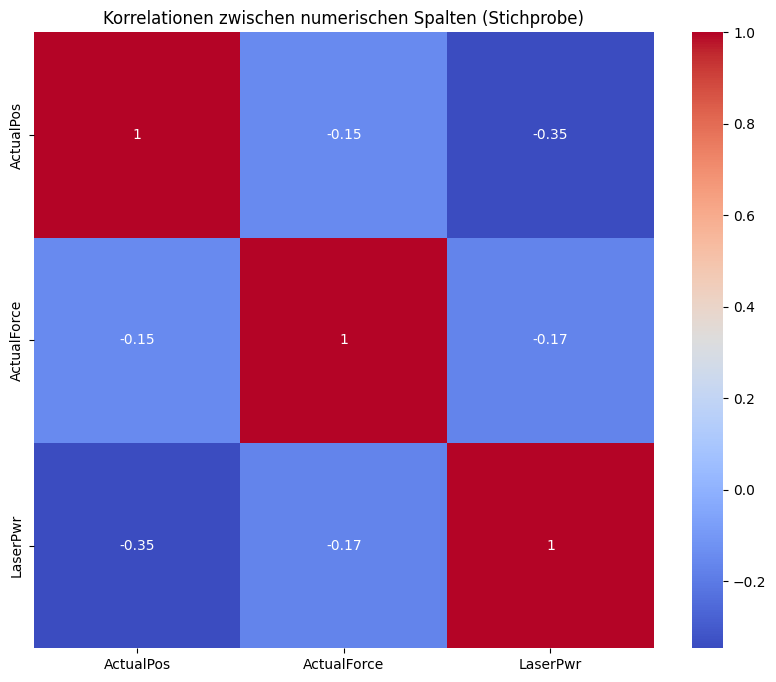

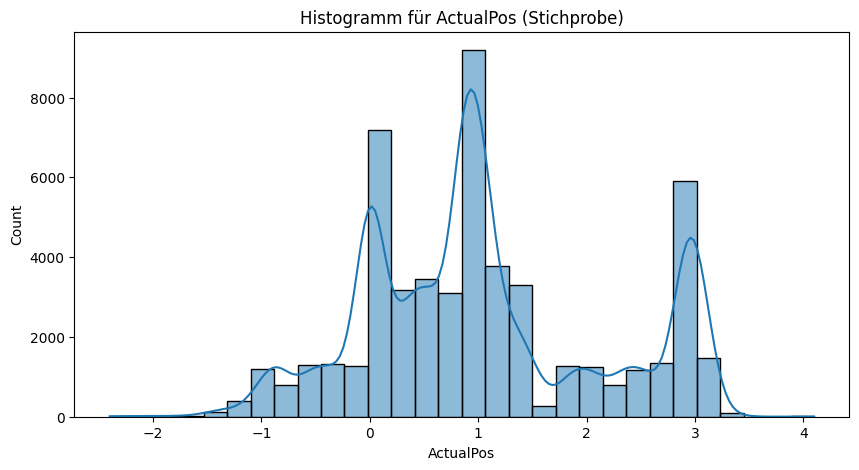

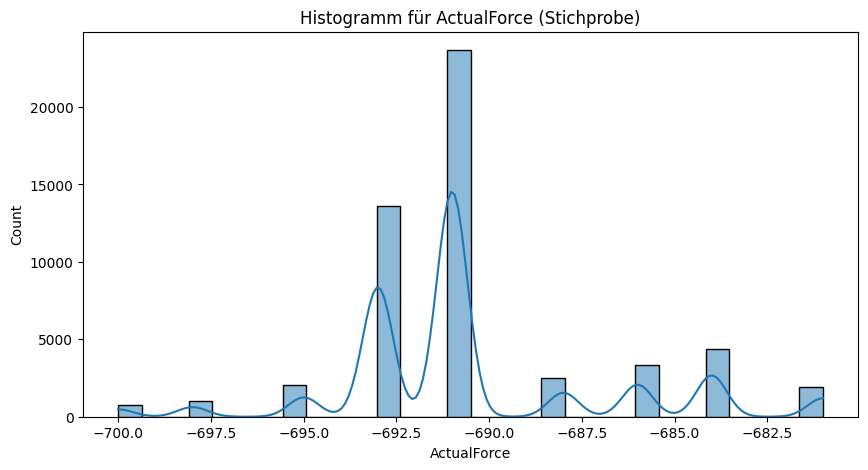

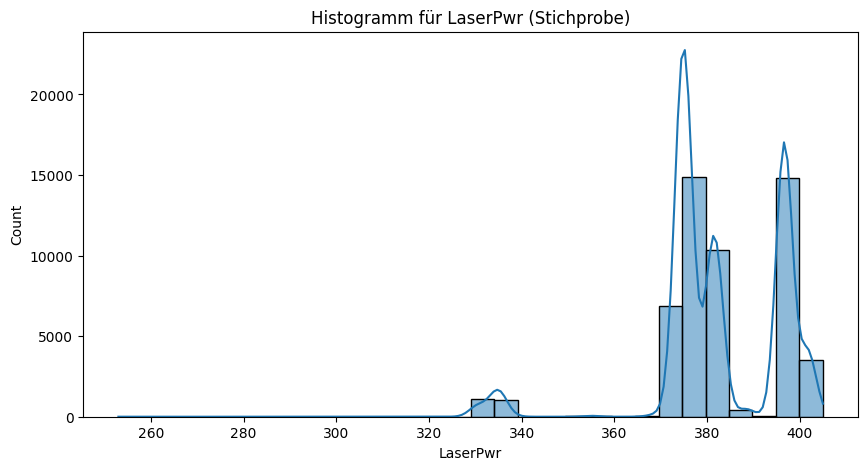

In [24]:
# Verbindung zur bereinigten SQLite-Datenbank herstellen
conn = sqlite3.connect('datenbank_clean.db')

# Tabelle aus der Datenbank lesen
clean_table_name = 'cleaned_data'
data = pd.read_sql(f"SELECT * FROM {clean_table_name}", conn)

# Verbindung schließen
conn.close()

# Prüfen, ob numerische Spalten vorhanden sind
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Stichprobe der Daten nehmen
sample_data = data.sample(frac=0.1, random_state=42)

# Methode 1: Visualisierung der Stichprobe
def visualize_sample_data(sample_data, numerical_columns):
    if len(numerical_columns) > 0:
        sns.pairplot(sample_data[numerical_columns])
        plt.suptitle("Pairplot der numerischen Spalten (Stichprobe)", y=1.02)
        plt.show()
    else:
        print("Keine numerischen Spalten für die Visualisierung gefunden.")

# Methode 2: Alternative Visualisierungen der Stichprobe
def alternative_visualizations_sample(sample_data, numerical_columns):
    if len(numerical_columns) > 0:
        # Heatmap der Korrelationen
        plt.figure(figsize=(10, 8))
        sns.heatmap(sample_data[numerical_columns].corr(), annot=True, cmap='coolwarm')
        plt.title("Korrelationen zwischen numerischen Spalten (Stichprobe)")
        plt.show()

        # Histogramme für numerische Spalten
        for column in numerical_columns:
            plt.figure(figsize=(10, 5))
            sns.histplot(sample_data[column], bins=30, kde=True)
            plt.title(f"Histogramm für {column} (Stichprobe)")
            plt.show()
    else:
        print("Keine numerischen Spalten für alternative Visualisierungen gefunden.")

# Aufruf der Methoden mit der Stichprobe
visualize_sample_data(sample_data, numerical_columns)
alternative_visualizations_sample(sample_data, numerical_columns)

# 4. Anomalieerkennung und 3D-Visualisierung

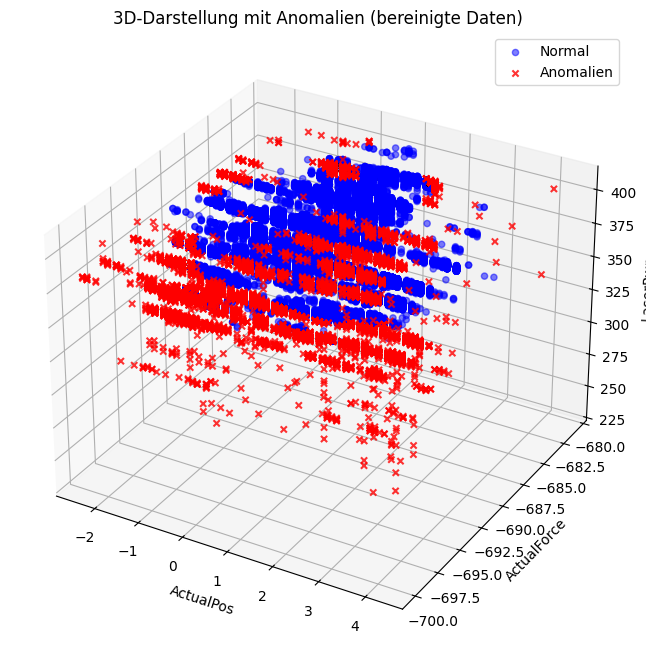

In [25]:
# Verbindung zur SQLite-Datenbank herstellen
db_path = 'datenbank_clean.db'
conn = sqlite3.connect(db_path)

# Tabellen in der Datenbank auflisten
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Daten aus der Tabelle 'cleaned_data' laden
table_name = 'cleaned_data'
data = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

# Nur numerische Spalten auswählen
numeric_data = data.select_dtypes(include=[np.number])

# Nur numerische Spalten auswählen
filtered_data = numeric_data.copy()

# IsolationForest auf die bereinigten Daten anwenden
iso_forest = IsolationForest(contamination=0.05, random_state=42)
filtered_data.loc[:, 'anomaly'] = iso_forest.fit_predict(filtered_data)

# 3D-Plot der bereinigten Daten mit Anomalien
x_col, y_col, z_col = filtered_data.select_dtypes(include=[np.number]).columns[:3]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalpunkte (anomaly = 1)
normal_data = filtered_data[filtered_data['anomaly'] == 1]
ax.scatter(normal_data[x_col], normal_data[y_col], normal_data[z_col], c='b', marker='o', alpha=0.5, label='Normal')

# Anomalien (anomaly = -1)
anomalies = filtered_data[filtered_data['anomaly'] == -1]
ax.scatter(anomalies[x_col], anomalies[y_col], anomalies[z_col], c='r', marker='x', alpha=0.8, label='Anomalien')

ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("3D-Darstellung mit Anomalien (bereinigte Daten)")
ax.legend()
plt.show()

# Verbindung zur ursprünglichen Datenbank schließen
conn.close()

# 5. 3D-Visualisierung für alle Spaltenkombinationen

In [26]:
import os
import itertools
import sqlite3
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Verbindung zur SQLite-Datenbank herstellen
db_path = 'datenbank_clean.db'
conn = sqlite3.connect(db_path)

# Daten aus der Tabelle 'cleaned_data' laden
table_name = 'cleaned_data'
filtered_data = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

# Verbindung zur Datenbank schließen
conn.close()

# Konvertiere 'TimeStamp' in numerisches Format (Unix-Zeitstempel), falls benötigt
if 'TimeStamp' in filtered_data.columns:
    filtered_data['TimeStamp'] = pd.to_datetime(filtered_data['TimeStamp'], errors='coerce').astype('int64') // 10**9

# Ordner für die gespeicherten Bilder erstellen
base_output_folder = "3D_Graphs_Combinations"
if not os.path.exists(base_output_folder):
    os.makedirs(base_output_folder)

# Liste der Spalten für die Kombinationen (einschließlich 'TimeStamp' für Visualisierung, aber nicht für IsolationForest)
columns = ['ActualPos', 'ActualForce', 'LaserPwr', 'TimeStamp']

# Alle möglichen Kombinationen von 3 Spalten erstellen
combinations = list(itertools.combinations(columns, 3))

# Iteriere über alle Kombinationen
for combination in combinations:
    x_col, y_col, z_col = combination

    # Ordner für die aktuelle Kombination erstellen
    combination_folder = f"{base_output_folder}/{x_col}_{y_col}_{z_col}"
    if not os.path.exists(combination_folder):
        os.makedirs(combination_folder)

    # Iteriere über alle Befehle
    unique_commands = filtered_data['Befehl'].unique()

    for command in unique_commands:
        # Daten für den aktuellen Befehl filtern und eine Kopie erstellen
        command_data = filtered_data[filtered_data['Befehl'] == command].copy()

        # Sicherstellen, dass die benötigten Spalten vorhanden sind
        if not all(col in command_data.columns for col in combination):
            print(f"Spalten {combination} nicht verfügbar für Befehl '{command}'.")
            continue

        # IsolationForest nur auf numerische Spalten ohne 'TimeStamp' anwenden
        numeric_cols = [col for col in [x_col, y_col, z_col] if col != 'TimeStamp']
        if numeric_cols:
            iso_forest = IsolationForest(contamination=0.05, random_state=42)
            command_data['anomaly'] = iso_forest.fit_predict(command_data[numeric_cols])
        else:
            command_data['anomaly'] = 1  # Keine Anomalien markieren, wenn nur 'TimeStamp' verwendet wird

        # 3D-Plot erstellen
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Normalpunkte (anomaly = 1)
        normal_data = command_data[command_data['anomaly'] == 1]
        ax.scatter(normal_data[x_col], normal_data[y_col], normal_data[z_col], c='b', marker='o', alpha=0.5, label='Normal')

        # Anomalien (anomaly = -1)
        anomalies = command_data[command_data['anomaly'] == -1]
        ax.scatter(anomalies[x_col], anomalies[y_col], anomalies[z_col], c='r', marker='x', alpha=0.8, label='Anomalien')

        # Achsen und Titel setzen
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_zlabel(z_col)
        ax.set_title(f"3D-Darstellung mit Anomalien für Befehl '{command}'")
        ax.legend()

        # Bild speichern
        output_path = os.path.join(combination_folder, f"3D_Graph_Befehl_{command}.png")
        plt.savefig(output_path)
        plt.close(fig)  # Schließt die Figur, um Speicher zu sparen

        print(f"3D-Graph für Befehl '{command}' mit Kombination {combination} wurde gespeichert")

print(f"Alle 3D-Graphen wurden im Ordner '{base_output_folder}' gespeichert.")

3D-Graph für Befehl 'PUTG348_46362103' mit Kombination ('ActualPos', 'ActualForce', 'LaserPwr') wurde gespeichert
3D-Graph für Befehl 'PNB398' mit Kombination ('ActualPos', 'ActualForce', 'LaserPwr') wurde gespeichert
3D-Graph für Befehl 'PUTG348_46360609' mit Kombination ('ActualPos', 'ActualForce', 'LaserPwr') wurde gespeichert
3D-Graph für Befehl 'PUTG348_46360610' mit Kombination ('ActualPos', 'ActualForce', 'LaserPwr') wurde gespeichert
3D-Graph für Befehl 'PUTG348_46360622' mit Kombination ('ActualPos', 'ActualForce', 'LaserPwr') wurde gespeichert
3D-Graph für Befehl 'PUTG348_46360623' mit Kombination ('ActualPos', 'ActualForce', 'LaserPwr') wurde gespeichert
3D-Graph für Befehl 'PNB390' mit Kombination ('ActualPos', 'ActualForce', 'LaserPwr') wurde gespeichert
3D-Graph für Befehl 'PUTG348_46360608' mit Kombination ('ActualPos', 'ActualForce', 'LaserPwr') wurde gespeichert
3D-Graph für Befehl 'PUTG348_46360632' mit Kombination ('ActualPos', 'ActualForce', 'LaserPwr') wurde gespei